In [32]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 2A: Overall step size distribution
* Figure 2B: Step size by parental origin
* Figure 2C: Direction of effect bias

**Extended Data Figures**
* Extended Data Figure 3A: Step size by period
* Extended Data Figure 3B/C: Step size by parental origin
* Extended Data Figure 3D/E: Direction bias homozygous vs. heterozygous

**Statistics**
* Supp Table 4: percent of step sizes that are a single unit
* Expansion/contraction bias with and without homopolymers
* Bias in maternal vs. paternal germline expansion TODO

In [33]:
# Input mutation results 
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation.bed"

# Output path info
OUTDIR = "pdfs/"

In [34]:
# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")

# Load expansions identified using naive method
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove remaining problematic families.
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot[["chrom","pos","end"]], on=["chrom","pos"])

# Figure 2A: Overall step size distribution

In [36]:
NUMSTEPS = 15 # show mutations +/- this number
bins = bins=np.arange(-1*NUMSTEPS,NUMSTEPS+1,1)

def BinomTest(data):
    #### Binom Test
    #the number of successes = number of expansions
    nexp = np.sum(data["mutsize"]>0)
    n = data.shape[0]
    print("n=",n)
    print("expansions=%1.2f"%(nexp/n))
    print("contractions=%1.2f"%(1-(nexp/n)))
    print("Binomial pval=%s"%scipy.stats.binom_test(nexp, n=n, p=0.5, alternative='two-sided'))

In [44]:
# How many mutations are expansions vs. contractions
BinomTest(adata) # overall
BinomTest(adata[adata["period"]>1]) # exclude homopolymers

n= 171578
expansions=0.71
contractions=0.29
Binomial pval=1.5e-323
n= 71822
expansions=0.56
contractions=0.44
Binomial pval=4.820949975734548e-249


171578


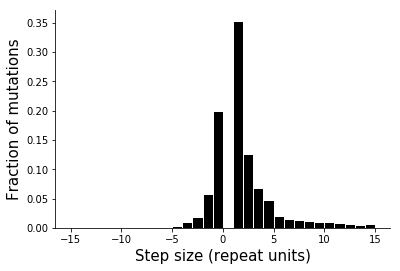

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)

plotdata = adata
print(plotdata.shape[0])
ax.hist(plotdata["mutsize"], color="black", edgecolor="white", bins=bins,
       weights=np.zeros_like(plotdata["mutsize"]) + 1. / plotdata["mutsize"].size);

ax.set_xlabel("Step size (repeat units)", size=15)
ax.set_ylabel("Fraction of mutations", size=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "Figure2_StepSize-All.pdf"))

# Figure 2B: step size by parental origin

Period 1
MannwhitneyuResult(statistic=68346695.0, pvalue=4.0268488131390715e-10)
Num pat: 12654
Num mat: 11308
Period 2
MannwhitneyuResult(statistic=37948549.0, pvalue=5.5251755616526016e-238)
Num pat: 17308
Num mat: 5886
Period 3
MannwhitneyuResult(statistic=814108.5, pvalue=7.710652861310258e-12)
Num pat: 2048
Num mat: 896
Period 4
MannwhitneyuResult(statistic=5040744.0, pvalue=1.411427131221745e-68)
Num pat: 6137
Num mat: 1916
Period 5
MannwhitneyuResult(statistic=186497.0, pvalue=0.0023179448637239263)
Num pat: 938
Num mat: 425
1.0
2.0
MannwhitneyuResult(statistic=316456830.0, pvalue=0.0)


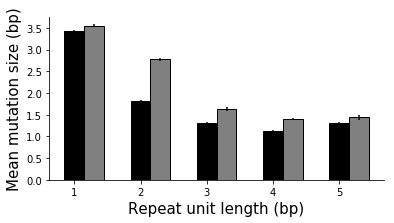

In [46]:
# Redo based on POO
periods = range(1, 6)
mean_steps_mother = []
mean_steps_father = []
stderr_steps_mother = []
stderr_steps_father = []

MAXSTEP = 25 # don't count anything outrageous

for period in periods:
    xdata1 = adata[(adata["period"]==period) & (adata["poocase"]==2)]["mutsize"]
    xdata1 = xdata1[abs(xdata1)<=MAXSTEP]
    xdata2 = adata[(adata["period"]==period) & (adata["poocase"]==3)]["mutsize"]
    xdata2 = xdata2[abs(xdata2)<=MAXSTEP]

    xdata1 = abs(xdata1)
    xdata2 = abs(xdata2)
    
    mean_steps_father.append(np.mean(xdata1))
    mean_steps_mother.append(np.mean(xdata2))
    stderr_steps_father.append(np.sqrt(np.var(xdata1)/len(xdata1)))
    stderr_steps_mother.append(np.sqrt(np.var(xdata2)/len(xdata2)))
    
    print("Period %s"%period)
    try:
        print(scipy.stats.mannwhitneyu(xdata1, xdata2, alternative="less"))
        print("Num pat: %s"%len(xdata1))
        print("Num mat: %s"%len(xdata2))
    except: pass

# overall
xdata1 = adata[ (adata["poocase"]==2)]["mutsize"]
xdata1 = xdata1[abs(xdata1)<=MAXSTEP]
xdata2 = adata[ (adata["poocase"]==3)]["mutsize"]
xdata2 = xdata2[abs(xdata2)<=MAXSTEP]
xdata1 = abs(xdata1)
xdata2 = abs(xdata2)
print(np.median(xdata1))
print(np.median(xdata2))
print(scipy.stats.mannwhitneyu(xdata1, xdata2, alternative="less"))

w = 0.3
fig = plt.figure()
fig.set_size_inches((6, 3))
ax = fig.add_subplot(111)
ax.bar(periods, mean_steps_father, yerr=stderr_steps_father, width=w, color="black", edgecolor="black");
ax.bar([item+w for item in periods], mean_steps_mother, yerr=stderr_steps_mother, width=w, color="gray", edgecolor="black");
ax.set_xlabel("Repeat unit length (bp)", size=15)
ax.set_ylabel("Mean mutation size (bp)", size=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "Figure2_POOSizeBias.pdf"))

# Extended Data Figure 3b: Step size - paternal

Father (excluding homopolymers)
n= 26550
expansions=0.50
contractions=0.50
Binomial pval=0.708132034297905


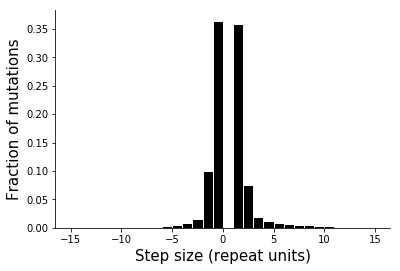

In [39]:
#### FATHER
print("Father (excluding homopolymers)")
fig = plt.figure()
ax = fig.add_subplot(111)

plotdata = adata[(adata.chrom!="X") & (adata["period"]>1) & (adata["poocase"]==2)].copy()
ax.hist(plotdata["mutsize"], color="black", edgecolor="white", bins=bins,
       weights=np.zeros_like(plotdata["mutsize"]) + 1. / plotdata["mutsize"].size);

ax.set_xlabel("Step size (repeat units)", size=15)
ax.set_ylabel("Fraction of mutations", size=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "SuppFig_StepSize-FATHER.pdf"))

#### Binom Test
BinomTest(plotdata)

# Extended Data Figure 3c: Step size - maternal

Mother (excluding homopolymers)
n= 9190
expansions=0.57
contractions=0.43
Binomial pval=3.716787922576764e-39


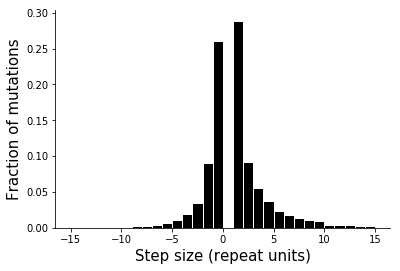

In [40]:
#### MOTHER 
print("Mother (excluding homopolymers)")
fig = plt.figure()
ax = fig.add_subplot(111)

plotdata = adata[(adata.chrom!="X") & (adata["period"]>1) & (adata["poocase"]==3)].copy()
ax.hist(plotdata["mutsize"], color="black", edgecolor="white", bins=bins,
       weights=np.zeros_like(plotdata["mutsize"]) + 1. / plotdata["mutsize"].size);

ax.set_xlabel("Step size (repeat units)", size=15)
ax.set_ylabel("Fraction of mutations", size=15)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');

fig.savefig(os.path.join(OUTDIR, "SuppFig_StepSize-MOTHER.pdf"))

#### Binom Test
BinomTest(plotdata)

# Extended Data Figure 3a: Step size by period/Table S4 "p" param

Period 1=0.47
99021
Period 2=0.59
41787
Period 3=0.74
6662
Period 4=0.86
18763
Period 5=0.73
3438
Period 6=0.43
705


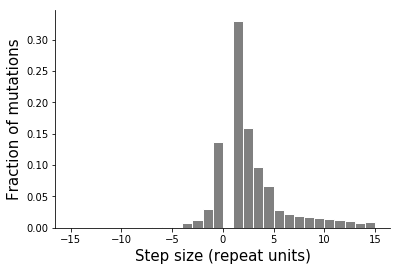

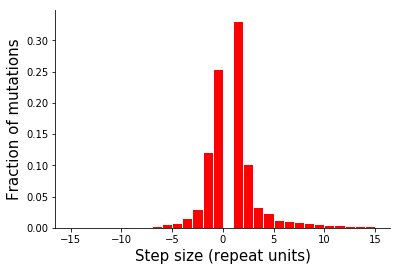

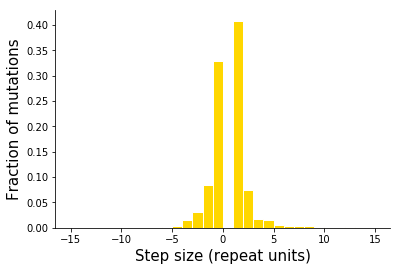

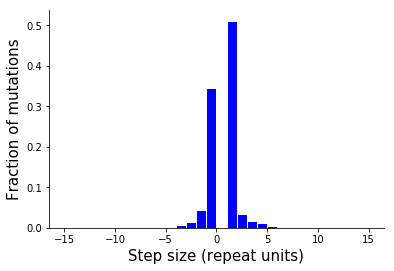

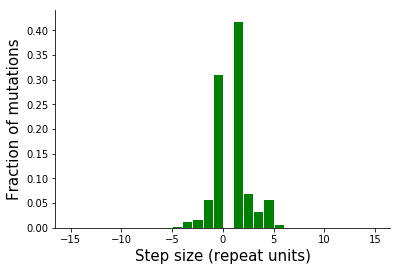

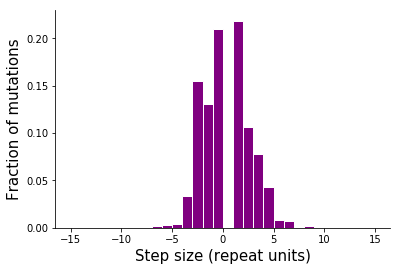

In [41]:
for period in range(1, 7):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xdata = adata[(adata["period"]==period)]["mutsize"]
    xdata = xdata[abs(xdata)<=NUMSTEPS]
    ax.hist(xdata, color=colors[period-1], edgecolor="white", bins=bins,
       weights=np.zeros_like(xdata) + 1. / xdata.size);

    ax.set_xlabel("Step size (repeat units)", size=15)
    ax.set_ylabel("Fraction of mutations", size=15)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');

    fig.savefig(os.path.join(OUTDIR, "SuppFig_StepSize-Period%s.pdf"%period))
    
    # Print "p", estimate of num mutations with abs(step)==1
    # Expecting to be close to 1 for tri and above
    print("Period %s=%.2f"%(period, np.mean(xdata.apply(abs)==1)))
    print(xdata.shape[0])

# Figure 2C/Extended Data Figure 3d-e: Directionality bias

In [42]:
# First, get parent allele
def GetParentAllele(x):
    return x["newallele"]-x["mutsize"]
adata["parent_allele"] = adata.apply(lambda x: GetParentAllele(x), 1)

# Get reference allele
adata["ref_allele"] = adata.apply(lambda x: (int(x["end"])-int(x["pos"])+1)*1.0/int(x["period"]), 1)

# Get diff
binsize = 2
adata["parent_allele_refdiff"] = (adata["parent_allele"]-adata["ref_allele"]).apply(lambda x: int(x/binsize)*binsize)

adata["mat_hom"] = adata["mat_gt"].apply(lambda x: len(set(x.split(",")))==1)
adata["pat_hom"] = adata["pat_gt"].apply(lambda x: len(set(x.split(",")))==1)

ALL
154831
Parent-hom
7219
Parent-het
8028


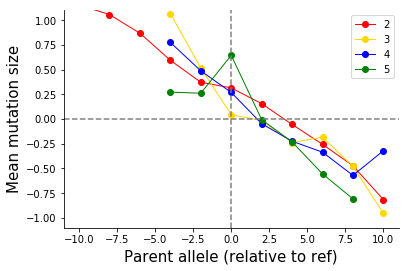

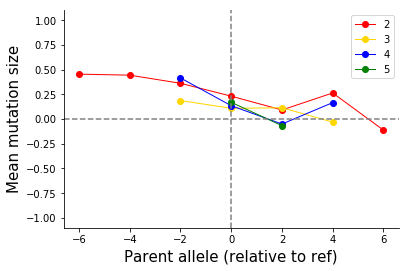

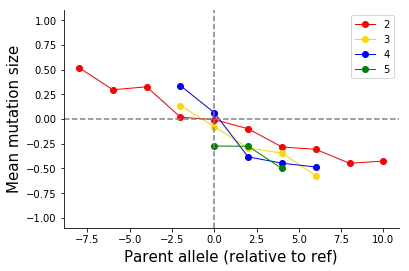

In [48]:
datasets = []
labels = []

# Use only data where mutations were phased
usedata = adata[(adata["mutsize"].apply(abs)<=5)]; fname = "Figure2_LengthBias.pdf"
datasets.append(usedata)
labels.append("ALL")

# Homozygous parent
usedata = adata[(((adata["poocase"]==2)&(adata["pat_hom"])) |
                 ((adata["poocase"]==3)&(adata["mat_hom"]))) & (adata["mutsize"].apply(abs)<=1)
               & (adata["encl_child"]>10)]; fname = "SuppFigure_LengthBias-Hom.pdf"
datasets.append(usedata)
labels.append("Parent-hom")

# Heterozygous parent
usedata = adata[(((adata["poocase"]==2)&(~adata["pat_hom"])) |
                 ((adata["poocase"]==3)&(~adata["mat_hom"]))) & (adata["mutsize"].apply(abs)<=1)
               & (adata["encl_child"]>10)] ; fname = "SuppFigure_LengthBias-Het.pdf"
datasets.append(usedata)
labels.append("Parent-het")

maxallele = 10
MINCALLS = 25

for i in range(len(datasets)):
    usedata = datasets[i]
    label = labels[i]
    
    print(label)
    print(usedata.shape[0])
    
    # Set up figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot by period
    for period in range(2, 6):
        lw = 1
        if period == 1: lw = 0.5
        bias = usedata[usedata["period"]==period].groupby("parent_allele_refdiff", as_index=False).agg({"mutsize": np.mean,"newallele": len})
        bias = bias[(bias["parent_allele_refdiff"].apply(abs)<=maxallele) & (bias["newallele"]>=MINCALLS)]
        ax.plot(bias["parent_allele_refdiff"], bias["mutsize"], marker="o", color=colors[period-1], label=period,
               linewidth=lw)

    ax.legend(loc="upper right");

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');

    ax.set_xlabel("Parent allele (relative to ref)", size=15)
    ax.set_ylabel("Mean mutation size", size=15)
    ax.axhline(y=0, linestyle="dashed", color="gray")
    ax.axvline(x=0, linestyle="dashed", color="gray")
    ax.set_ylim(bottom=-1.1, top=1.1)
    if label == "ALL":
        fname = "Figure2_LengthBias.pdf"
    else: fname = "SuppFig_LengthBias_%s.pdf"%label
    fig.savefig(os.path.join(OUTDIR, fname))